# Aprendizaje de máquina

   Desarrollada la separación del contenido del CAPTCHA, el siguiente paso es crear una red neuronal que nos 
   permita identificar a qué corresponde cada imagen generada. Esto mediante Python3.
   
   Para tal fin, primero generamos un dataset que nos sirva para entrenar y posterior análisis de las imagenes
   que necesitamos identificar. Para tal fin, tomamos distintas imágenes correspondientes a letras y números,
   para después ajustarlas como base de datos y entrada de entrenamiento a nuestra red neuronal, en 
   el presente caso utilizamos el clasificador de imágenes tf2-preview/mobilenet_v2/classification  de 
   tensorflow.  

In /home/diego/.config/matplotlib/stylelib/belle2_serif.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/diego/.config/matplotlib/stylelib/belle2_serif.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/diego/.config/matplotlib/stylelib/belle2_serif.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/diego/.config/matplotlib/stylelib/belle2.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/diego/.config/matplotlib/stylelib/belle2.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead

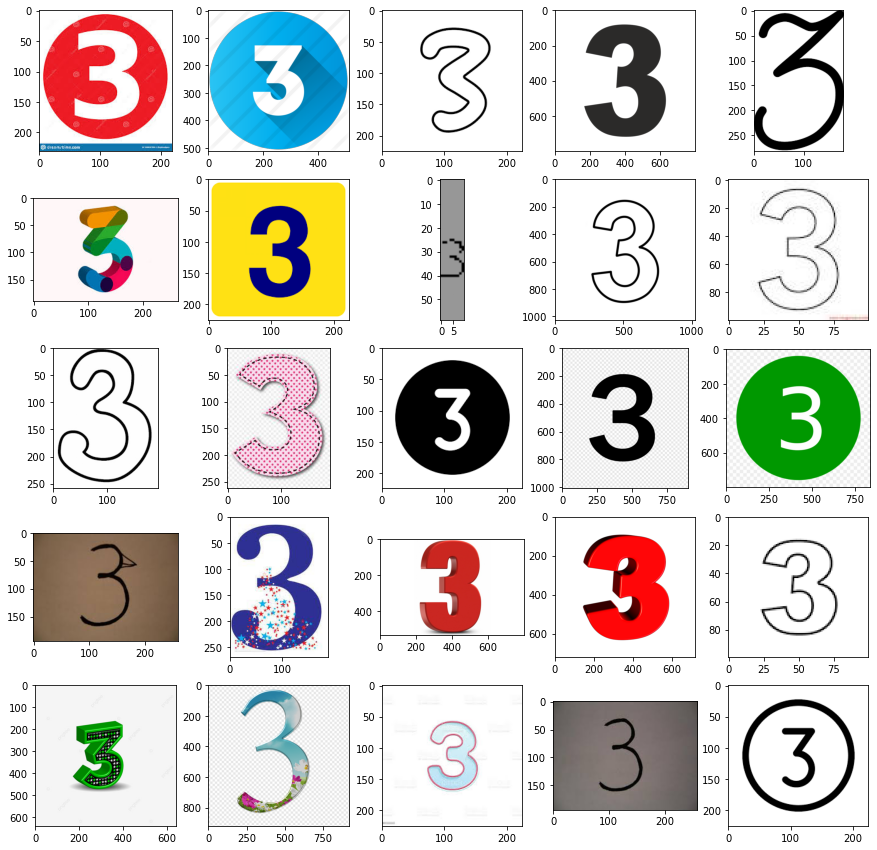

In [1]:
# primero se descargan las imágenes de letras y números en carpetas individuales, se descartan de forma manual
# las imágenes que no aportan contenido, aquí se muestra como ejemplo las imágenes de numeros 3

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(15,15))

carpeta = './3'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
    plt.subplot(5,5,i+1)
    imagen = mpimg.imread(carpeta + '/' + nombreimg,0)
    plt.imshow(imagen)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(
    rescale=1. /255,
    rotation_range =30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range =15,
    zoom_range = [0.5, 1.5],
    validation_split = 0.2  
)

In [3]:
# En este caso, haremos la prueba con el número 3 y las letras Q y S. Para esto se tienen 3 carpetas con
# imágenes del número y las letras por separado, esto con el fin de hacer nuestra propia base de entrenamiento
# solamente dejaremos 199 de ellas en todas para igualar el contenido del dataset.
# Aquí se realiza esto sacando de la carpeta de descarga a una nueva carpeta con las 199 imágenes.

import shutil

carpeta_fuente = './3'
carpeta_destino = './dataset/3'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
    if i < 199:
        shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [4]:
# Para la Q
carpeta_fuente = './Q'
carpeta_destino = './dataset/Q'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
    if i < 199:
        shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [5]:
# Para la S
carpeta_fuente = './S'
carpeta_destino = './dataset/S'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
    if i < 199:
        shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [6]:
# Dado que tenemos pocas imágenes, utilizamos aumento de datos, en donde hacemos transformaciones a nuestro 
# dataset, para que esto signifique más dataset útil

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(
    rescale=1. /255,
    rotation_range =30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range =15,
    zoom_range = [0.5, 1.5],
    validation_split = 0.2  # aquí decimos que el 20% es para pruebas
)

Found 479 images belonging to 3 classes.
Found 117 images belonging to 3 classes.


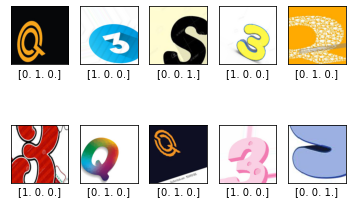

In [7]:
# Aquí indicamos los datos de entrenamiento y de prueba

data_gen_entrenamiento = datagen.flow_from_directory('./dataset', target_size=(224,224),
                                                    batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('./dataset', target_size=(224,224),
                                                    batch_size=32, shuffle=True, subset='validation')

for imagen, etiqueta in data_gen_entrenamiento:
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(etiqueta[i])
        plt.imshow(imagen[i])
    break
plt.show()

# Como ejemplo imprimimos 10 imágenes y la correspondiente etiqueta

In [8]:
# Ahora aplicamos un modelo pre-entrenado de tensorflow para clasificación de imágenes

import tensorflow as tf
import tensorflow_hub as hub

url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4' # dirección del clasificador
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3)) # descarga del modelo

In [9]:
mobilenetv2.trainable = False # congelamos los parámetros previos que vienen en el modelo descargado

In [10]:
# creamos nuestro modelo de categorización

modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(3, activation='softmax')
])

In [11]:
# Algunas estadísticas resumen del modelo

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
# Se compila el modelo
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']

)

In [13]:
# y posteriormente entrenamos nuestro modelo

EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas

)

Epoch 1/50
15/15 [==============================] - 27s 1s/step - loss: 1.1440 - accuracy: 0.4426 - val_loss: 1.0096 - val_accuracy: 0.5214
Epoch 2/50
15/15 [==============================] - 19s 1s/step - loss: 0.9007 - accuracy: 0.5741 - val_loss: 0.9549 - val_accuracy: 0.5128
Epoch 3/50
15/15 [==============================] - 18s 1s/step - loss: 0.7353 - accuracy: 0.7015 - val_loss: 0.7779 - val_accuracy: 0.6239
Epoch 4/50
15/15 [==============================] - 19s 1s/step - loss: 0.6789 - accuracy: 0.7119 - val_loss: 0.7567 - val_accuracy: 0.6923
Epoch 5/50
15/15 [==============================] - 19s 1s/step - loss: 0.6472 - accuracy: 0.7349 - val_loss: 0.8424 - val_accuracy: 0.6068
Epoch 6/50
15/15 [==============================] - 19s 1s/step - loss: 0.5936 - accuracy: 0.7662 - val_loss: 0.7368 - val_accuracy: 0.6923
Epoch 7/50
15/15 [==============================] - 18s 1s/step - loss: 0.5658 - accuracy: 0.7662 - val_loss: 0.7617 - val_accuracy: 0.6496
Epoch 8/50
15/15 [==

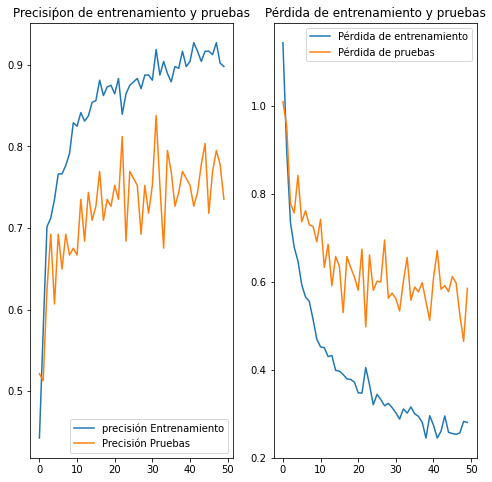

In [14]:
# En esta parte, desarrollamos gráficas de precisión
# Dado que no se añadieron gran número de imágenes muestra, no se obtuvo una precisión adecuada
# las gráficas por lo tanto no coinciden mucho POR AHORA!! OBJETIVO MEJORARLAS!

acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisiṕon de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [15]:
# Finalmente, se crea una función que categorice la imágen que deseemos
import cv2

def caracterizador(img):
    img = cv2.imread(img)

    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1,224,224,3))
    carac = np.argmax(prediccion[0], axis=-1)
    
    if carac == 0:
        r = print('Es la 3')
    elif carac == 1:
        r = print('Es la Q')
    elif carac == 2:
        r = print('Es la S')
    return r

In [16]:
# imágenes pruebas 
prueba1 = './pruebaQ.jpg'
caracterizador(prueba1)

Es la Q


In [17]:
prueba2 = './pruebaS.jpg'
caracterizador(prueba2)

Es la S


In [18]:
prueba3 = './prueba3.jpg'
caracterizador(prueba3)

Es la 3
